<a href="https://colab.research.google.com/github/yigitv4rli/CENG501-Spring2022/blob/main/Project_Kose_Varli/experiments/ijcnn1_experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import libraries here
import torch 
import math
import json
import pandas as pd
import random
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import torchvision 
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data import DataLoader
from google.colab import drive
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
seed_alg = random.randint(0,100)
torch.manual_seed(seed_alg)
drive.mount('/content/gdrive')

! wget https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/w8a
! wget https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/w8a.t
! wget https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/ijcnn1.tr.bz2
! wget https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/ijcnn1.t.bz2
! wget https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/ijcnn1.val.bz2
! bunzip2 ijcnn1.tr.bz2
! bunzip2 ijcnn1.t.bz2
! bunzip2 ijcnn1.val.bz2

Mounted at /content/gdrive
--2022-07-06 22:14:23--  https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/w8a
Resolving www.csie.ntu.edu.tw (www.csie.ntu.edu.tw)... 140.112.30.26
Connecting to www.csie.ntu.edu.tw (www.csie.ntu.edu.tw)|140.112.30.26|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3478238 (3.3M)
Saving to: ‘w8a’

w8a                 100%[===================>]   3.32M  3.40MB/s    in 1.0s    

2022-07-06 22:14:25 (3.40 MB/s) - ‘w8a’ saved [3478238/3478238]

--2022-07-06 22:14:25--  https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/w8a.t
Resolving www.csie.ntu.edu.tw (www.csie.ntu.edu.tw)... 140.112.30.26
Connecting to www.csie.ntu.edu.tw (www.csie.ntu.edu.tw)|140.112.30.26|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1045870 (1021K) [text/troff]
Saving to: ‘w8a.t’

w8a.t               100%[===================>]   1021K  1.21MB/s    in 0.8s    

2022-07-06 22:14:27 (1.21 MB/s) - ‘w8a.t’ saved [104

# Utility Functions

This section includes utility functions for overall model
1. Learning Schedulers
2. Data Loaders
3. Train and Test Accuracy
4. Result Saving
5. Plotting

In [ ]:
# scheduler functions
def constant_learning_rate_scheduler(lr):
    def scheduler(_):
        return lr
    return scheduler

def cosine_learning_rate_scheduler(lr, epoch_count):
    def scheduler(current_epoch):
        return lr * (1 + math.cos(current_epoch * math.pi / epoch_count))
    return scheduler

def diminishing_learning_rate_scheduler(lr, alpha):
    def scheduler(current_epoch):
        return lr / ((current_epoch + alpha) ** (1/3))
    return scheduler

def exponential_learning_rate_scheduler(lr, alpha):
    def scheduler(current_epoch):
        return lr * (alpha ** current_epoch)
    return scheduler

def save_history_json(file_name, history):
  with open(file_name, "w") as out:
    json.dump(history, out)

In [ ]:
# data loaders for cifar10 and fashionmnist
def create_w8a_row(line):
    row = [0] * 300

    for non_zero in line[1:]:
        loc, value = non_zero.split(":")
        loc, value = int(loc), float(value)
        row[loc-1] = value
    return row


def w8a_data_create():
    w8a_x_train, w8a_y_train = list(), list()
    with open("w8a", "r") as f:
        lines = f.readlines()

        for line in lines:
            line = line.strip().split()
            w8a_y_train.append(float(line[0]))
            row = create_w8a_row(line)
            w8a_x_train.append(row)

    w8a_x_test, w8a_y_test = list(), list()
    with open("w8a.t", "r") as f:
        lines = f.readlines()

        for line in lines:
            line = line.strip().split()
            w8a_y_test.append(float(line[0]))
            row = create_w8a_row(line)
            w8a_x_test.append(row)

    return w8a_x_train, w8a_y_train, w8a_x_test, w8a_y_test

def w8a_data_loader(X_train, Y_train, X_test, Y_test, batch_size, ssmg):
    transform = transforms.Compose([transforms.ToTensor()])
    
    train_set = torch.utils.data.TensorDataset(X_train, Y_train)
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)

    # a check if the loader is called for Single Shuffling Momentum Gradient (SSMG)
    # we do shuffling once at the beginning then we create the train loader
    if ssmg:
        shuffled_set = torch.utils.data.Subset(train_set, torch.randperm(len(train_set)))
        train_loader = torch.utils.data.DataLoader(shuffled_set, batch_size=batch_size,
                                            shuffle=False, num_workers=2)

    test_set = torch.utils.data.TensorDataset(X_test, Y_test)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

w8a_x_train, w8a_y_train, w8a_x_test, w8a_y_test = w8a_data_create()
w8a_X_train, w8a_Y_train = torch.Tensor(w8a_x_train), torch.Tensor(w8a_y_train)
w8a_X_test, w8a_Y_test = torch.Tensor(w8a_x_test), torch.Tensor(w8a_y_test)
w8a_X_train = torch.reshape(w8a_X_train, (w8a_X_train.shape[0], w8a_X_train.shape[1], 1))
w8a_Y_train = torch.reshape(w8a_Y_train, (w8a_Y_train.shape[0], 1))

w8a_X_test = torch.reshape(w8a_X_test, (w8a_X_test.shape[0], w8a_X_test.shape[1], 1))
w8a_Y_test = torch.reshape(w8a_Y_test, (w8a_Y_test.shape[0], 1))

# loaders for w8a
w8a_train_loader, w8a_test_loader = w8a_data_loader(w8a_X_train, w8a_Y_train, w8a_X_test, w8a_Y_test, 128, False)

In [ ]:
def create_ijcnn1_row(line):
    row = [0] * 22
    
    for non_zero in line[1:]:
        loc, value = non_zero.split(":")
        loc, value = int(loc), float(value)
        row[loc-1] = value
    return row

def ijcnn1_data_create():
    ijcnn1_x_train, ijcnn1_y_train = list(), list()
    with open("ijcnn1.tr", "r") as f:
        lines = f.readlines()

        for line in lines:
            line = line.strip().split()
            row = create_ijcnn1_row(line)
            ijcnn1_x_train.append(row)
            ijcnn1_y_train.append(float(line[0]))
    
    with open("ijcnn1.val", "r") as f:
        lines = f.readlines()

        for line in lines:
            line = line.strip().split()
            row = create_ijcnn1_row(line)
            ijcnn1_x_train.append(row)
            ijcnn1_y_train.append(float(line[0]))

    ijcnn1_x_test, ijcnn1_y_test = list(), list()
    with open("ijcnn1.t", "r") as f:
        lines = f.readlines()

        for line in lines:
            line = line.strip().split()
            row = create_ijcnn1_row(line)
            ijcnn1_x_test.append(row)
            ijcnn1_y_test.append(float(line[0]))
    
    return ijcnn1_x_train, ijcnn1_y_train, ijcnn1_x_test, ijcnn1_y_test

def ijcnn1_data_loader(X_train, Y_train, X_test, Y_test, batch_size, ssmg):
    transform = transforms.Compose([transforms.ToTensor()])
    
    train_set = torch.utils.data.TensorDataset(X_train, Y_train)
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)

    # a check if the loader is called for Single Shuffling Momentum Gradient (SSMG)
    # we do shuffling once at the beginning then we create the train loader
    if ssmg:
        shuffled_set = torch.utils.data.Subset(train_set, torch.randperm(len(train_set)))
        train_loader = torch.utils.data.DataLoader(shuffled_set, batch_size=batch_size,
                                            shuffle=False, num_workers=2)

    test_set = torch.utils.data.TensorDataset(X_test, Y_test)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader
 
ijcnn1_x_train, ijcnn1_y_train, ijcnn1_x_test, ijcnn1_y_test = ijcnn1_data_create()
ijcnn1_X_train, ijcnn1_Y_train = torch.Tensor(ijcnn1_x_train), torch.Tensor(ijcnn1_y_train)
ijcnn1_X_test, ijcnn1_Y_test = torch.Tensor(ijcnn1_x_test), torch.Tensor(ijcnn1_y_test)

ijcnn1_X_train = torch.reshape(ijcnn1_X_train, (ijcnn1_X_train.shape[0], ijcnn1_X_train.shape[1], 1))
ijcnn1_Y_train = torch.reshape(ijcnn1_Y_train, (ijcnn1_Y_train.shape[0], 1))

ijcnn1_X_test = torch.reshape(ijcnn1_X_test, (ijcnn1_X_test.shape[0], ijcnn1_X_test.shape[1], 1))
ijcnn1_Y_test = torch.reshape(ijcnn1_Y_test, (ijcnn1_Y_test.shape[0], 1))


# loaders for ijcnn1
ijcnn1_train_loader, ijcnn1_test_loader = ijcnn1_data_loader(ijcnn1_X_train, ijcnn1_Y_train, ijcnn1_X_test, ijcnn1_Y_test, 128, False)

In [ ]:
def train_and_test_accuracy(model, train_loader, test_loader):
    total, correct = 0, 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device) # 128-1 -1 veya 1
            predicted = torch.zeros(labels.shape)
            outputs = model(images) #128 - 1 scores
            for i, b in enumerate(outputs):
              if b < 0:
                predicted[i] = -1
              else:
                predicted[i] = 1
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    test_accuracy = 100 * correct / total

    total, correct = 0, 0
    with torch.no_grad():
        for data in train_loader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            predicted = torch.zeros(labels.shape)
            outputs = model(images)
            for i, b in enumerate(outputs):
              if b < 0:
                predicted[i] = -1
              else:
                predicted[i] = 1
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    train_accuracy = 100 * correct / total

    return train_accuracy, test_accuracy



In [11]:
def plot_loss(history):
    plt.legend(fontsize = 18)
    plt.xticks(size = 18)
    plt.yticks(size = 18)
    plt.xlabel('Number of effective passes', fontsize = 18)
    plt.ylabel('Train Loss', fontsize = 18)
    plt.yscale('log')
    loss_history = history['loss_history']
    x = [i for i in range(3,50, 3)]
    y = [np.sum(loss_history[y:y+3])/3 for y in range(0,47,3)]
    plt.plot(x, y, '-ok', color='blue')
    plt.show()

def plot_norm_square_grad(history):
    plt.xticks(size = 18)
    plt.yticks(size = 18)
    plt.xlabel('Number of effective passes', fontsize = 18)
    plt.ylabel('Grad loss', fontsize = 18)
    plt.yscale('log')
    grad_history = history['grad_history']
    x = [i for i in range(3,50, 3)]
    y = [np.sum(grad_history[y:y+3])/3 for y in range(0,47,3)]
    plt.plot(x, y, '-ok', color='red')
    plt.show()

# Network


In [ ]:
#This is a very basic single layer network which will be used for non-convex logistic regression problem
class NonconvexLogisticNet (nn.Module):
    def __init__ (self, I, O, batch_size):
        super().__init__()
        self.fc = nn.Linear(I, O, bias=True)
        self.batch_size = batch_size
        self.I = I




    def forward (self, x):
      #Flatten 
      #x = torch.reshape(x, (self.batch_size, self.I))
      x = torch.flatten(x, 1)
      x = torch.tanh(self.fc(x))
      return x

# Trainers Code Section

## SMG Train Function

In [ ]:
# This trainer trains the net using the SMG algorithm proposed in the paper.
# We named the variables identical with the paper's algorithm notation. Different from paper
# the types we used are PyTorch tensors.
def SMG_train(model, criterion, epochs, train_loader, test_loader, scheduler, beta, verbose=True):
  """
    Define the trainer function. We can use this for training any model.
    The parameter names are self-explanatory.

    Returns: the dictionary of history that includes loss, grads, test and train accuracies.
  """
  history = dict()
  history['loss_history'], history['grad_history'] = list(), list()
  history['test_acc_history'], history['train_acc_history'] = list(), list()
  
  #Note that velocity depends on gradient. So, per each different weight gradient we will have a different velocity, thus different momentum.
  #Therefore, we store velocity and momentum per weight seperately.
  m = dict()
  v = dict()
  # Initialize momentum and velocity dictionaries for weights with zeros.
  for n, w in model.named_parameters():
    m[n] = torch.zeros_like(w.data, memory_format = torch.preserve_format)
    v[n] = torch.zeros_like(w.data, memory_format = torch.preserve_format)



  #Note that we have activated shuffling. When iterator advances to the end
  #of the batches reshuffles. This is effectively shuffling the batch
  #before every batch.
  for epoch in range(epochs):
    total_loss = 0
    total_grad_norm = 0
    lr = scheduler(epoch+1)
    # At the beginning of each epoch
    # Set m = v
    for n, w in model.named_parameters():
      m[n] = v[n]
    
    # Set v = 0
    for n, w in model.named_parameters():
      v[n] = torch.zeros_like(w.data, memory_format = torch.preserve_format)


    for i, data in enumerate(train_loader, 0):    
      # Our batch:
      inputs, labels = data
      inputs = inputs.to(device)
      labels = labels.to(device)
      

      normalizer = labels.size(0) / len(train_loader.dataset)

      # zero the gradients as PyTorch accumulates them
      model.zero_grad()

      # Obtain the scores
      outputs = model(inputs)


      #Compute regularizing term
      reg = 0 #Will be accumulated
      l = 0.01 # Given in the paper

      
      #Obtain regularizer term from weights.
      for w in model.parameters():
        #For Nonconvex Logistic Regression Problem we also have regularization term to loss 
        with torch.no_grad():
          w_sq = w.data.detach().data.norm(2) ** 2
          reg += w_sq / 1 + w_sq  

      #Find the average value for batch
      reg /= labels.size(0)
      # Calculate loss with regularization term
      loss = criterion(outputs.to(device), labels) + (l/2.0)*reg 
      

      #Accumulate the loss of each iteration
      total_loss += loss.item() * normalizer

      # Backpropagate (Regularizer is on computation graph now so it will also be differentiated)
      loss.backward()

      
      # Paper proposes an alternative scheme to update the weights using momentum with batch shuffling. 
      for n, w in model.named_parameters():
        with torch.no_grad():
          #Pytorch computes a batch gradient which is 1/batch_size * grad. In update scheme we use 1/n so we set a grad_scale to compansate that.
          g_scale = labels.size(0) / len(train_loader.dataset) #batch_size / dataset_size
          #Update v
          v[n] += g_scale * w.grad.data
          delta = beta * m[n] + (1-beta) * w.grad.data #weight_update
          w.data += -lr * delta



      #Measure grad_square
      for p in model.parameters():
          param_norm = p.grad.detach().data.norm(2)
          total_grad_norm += param_norm.item() ** 2 * normalizer
      
    
    
    history['grad_history'].append(total_grad_norm)
    history['loss_history'].append(total_loss)
    
    train_acc, test_acc = train_and_test_accuracy(model, train_loader, test_loader)
    history['train_acc_history'].append(train_acc)
    history['test_acc_history'].append(test_acc)
    loss_history = history['loss_history']
    if verbose: print(f'Epoch {epoch+1} / {epochs}: avg. loss of last epoch {total_loss}')
    if verbose: print(f'avg. grad_norm of last epoch {total_grad_norm}')
    if verbose: print(f'Current train acc: {train_acc}%, test acc: {test_acc}%')
    
  return history

## SSMG Train Function

In [ ]:
# This trainer trains the net using the SSMG algorithm proposed in the paper.
# We named the variables identical with the paper's algorithm notation. Different from paper
# the types we used are PyTorch tensors. Also, SSMG is single shuffle variant of SMG so batches wont 
# be reshuffled every epoch.
def SSMG_train(model, criterion, epochs, train_loader, test_loader, scheduler, beta, verbose=True):
  """
    Define the trainer function. We can use this for training any model.
    The parameter names are self-explanatory.

    Returns: the dictionary of history that includes loss, grads, test and train accuracies.
  """
  history = dict()
  history['loss_history'], history['grad_history'] = list(), list()
  history['test_acc_history'], history['train_acc_history'] = list(), list()
  


  m = dict()
  # Initialize momentum dictionaries for weights with zeros.
  for n, w in model.named_parameters():
    m[n] = torch.zeros_like(w.data, memory_format = torch.preserve_format)



  #Note that we have activated shuffling. When iterator advances to the end
  #of the batches reshuffles. This is effectively shuffling the batch
  #before every batch.
  for epoch in range(epochs):
    total_loss = 0
    total_grad_norm = 0
    lr = scheduler(epoch+1)
  
    for i, data in enumerate(train_loader, 0):    
      # Our batch:
      inputs, labels = data
      inputs = inputs.to(device)
      labels = labels.to(device)

      #There is no momentum update here. We want to preserve the momentum value of the
      #previous epoch.

      normalizer = labels.size(0) / len(train_loader.dataset)

      # zero the gradients as PyTorch accumulates them
      model.zero_grad()

      # Obtain the scores
      outputs = model(inputs)

      #Compute regularizing term
      reg = 0 #Will be accumulated
      l = 0.01 # Given in the paper

      
      #Obtain regularizer term from weights.
      for w in model.parameters():
        #For Nonconvex Logistic Regression Problem we also have regularization term to loss 
        with torch.no_grad():
          w_sq = w.data.detach().data.norm(2) ** 2
          reg += w_sq / 1 + w_sq  

      
      #Find the average value for batch
      reg /= labels.size(0)
      # Calculate loss with regularization term
      loss = criterion(outputs.to(device), labels) + (l/2.0)*reg 

      #Accumulate the loss of each iteration
      total_loss += loss.item()* normalizer

      # Backpropagate
      loss.backward()

      # Paper proposes an alternative scheme to update the weights using momentum with single batch shuffling. 
      for n, w in model.named_parameters():
        with torch.no_grad():
          g_scale = labels.size(0) / len(train_loader.dataset) #batch_size / dataset_size
          #Update momentum in every iteration (Most important difference from SMG)
          m[n] = beta * m[n] + (1-beta) * w.grad.data
          w.data += -lr * m[n] #weight_update using the momentum directly



      #Measure grad_square
      for p in model.parameters():
          param_norm = p.grad.detach().data.norm(2)
          total_grad_norm += param_norm.item() ** 2 * normalizer
      
    
    
    history['grad_history'].append(total_grad_norm)
    history['loss_history'].append(total_loss)
    
    train_acc, test_acc = train_and_test_accuracy(model, train_loader, test_loader)
    history['train_acc_history'].append(train_acc)
    history['test_acc_history'].append(test_acc)
    loss_history = history['loss_history']
    if verbose: print(f'Epoch {epoch+1} / {epochs}: avg. loss of last epoch {total_loss}')
    if verbose: print(f'avg. grad_norm of last epoch {total_grad_norm}')
    if verbose: print(f'Current train acc: {train_acc}%, test acc: {test_acc}%')
    
  return history

## Train Function for Other Optimizers

In [ ]:
# This is a general trainer that uses PyTorch's built-in optimizers.
# This function will be used compare other optimizers with SMG
def train(model, criterion, optimizer, epochs, train_loader, test_loader, scheduler, verbose=True):
  """
    Define the trainer function. We can use this for training any model.
    The parameter names are self-explanatory.

    Returns: the dictionary of history that includes loss, grads, test and train accuracies.
  """


  history = dict()
  history['loss_history'], history['grad_history'] = list(), list()
  history['test_acc_history'], history['train_acc_history'] = list(), list()
  #Note that we have activated shuffling. When iterator advances to the end
  #of the batches reshuffles. This is effectively shuffling the batch
  #before every batch.
  for epoch in range(epochs):
    total_loss = 0
    total_grad_norm = 0
    lr = scheduler(epoch+1)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr 

    for i, data in enumerate(train_loader, 0):    
      # Our batch:
      inputs, labels = data
      inputs = inputs.to(device)
      labels = labels.to(device)

      normalizer = labels.size(0) / len(train_loader.dataset)


      # zero the gradients as PyTorch accumulates them
      optimizer.zero_grad()

      # Obtain the scores
      outputs = model(inputs)

      #Find the average value for batch
      reg = 0 #Will be accumulated
      l = 0.01 # Given in the paper

      
      #Obtain regularizer term from weights.
      for w in model.parameters():
        #For Nonconvex Logistic Regression Problem we also have regularization term to loss 
        with torch.no_grad():
          w_sq = w.data.detach().data.norm(2) ** 2
          reg += w_sq / 1 + w_sq  

      
      #Find the average value for batch
      reg /= labels.size(0)
      # Calculate loss with regularization term
      loss = criterion(outputs.to(device), labels) + (l/2.0)*reg 

      #Accumulate the loss of each iteration
      total_loss += loss.item()* normalizer

      # Backpropagate
      loss.backward()

      # Update the weights
      optimizer.step()

      
      #Measure grad_square
      for p in model.parameters():
          param_norm = p.grad.detach().data.norm(2)
          total_grad_norm += param_norm.item() ** 2 * normalizer
      

    history['grad_history'].append(total_grad_norm)
    history['loss_history'].append(total_loss)

    train_acc, test_acc = train_and_test_accuracy(model, train_loader, test_loader)
    history['train_acc_history'].append(train_acc)
    history['test_acc_history'].append(test_acc)
    loss_history = history['loss_history']
    if verbose: print(f'Epoch {epoch+1} / {epochs}: avg. loss of last epoch {total_loss}')
    if verbose: print(f'Epoch {epoch+1} / {epochs}: avg. grad_norm of last epoch {total_grad_norm}')
    if verbose: print(f'Current train acc: {train_acc}%, test acc: {test_acc}%')  

  return history

# Get GPU

In [ ]:
if torch.cuda.is_available():
  print("Cuda (GPU support) is available and enabled!")
  device = torch.device("cuda")
else:
  print("Cuda (GPU support) is not available :(")
  device = torch.device("cpu")

Cuda (GPU support) is not available :(


# 1- Train and Plot Different Learning Schedulers over SMG

## SMG with Constant Learning Rate Scheduler

In [ ]:
import torch.optim as optim

criterion = nn.SoftMarginLoss()

model = NonconvexLogisticNet(22, 1, 128)
model = model.to(device)
epochs = 50


scheduler = constant_learning_rate_scheduler(0.001)

# beta is proposed in paper and epoch_count is inferenced from the graphs
history = SMG_train(model, criterion, epochs, ijcnn1_train_loader, ijcnn1_test_loader, 
                    scheduler, beta=0.5, verbose=True)

Epoch 1 / 50: avg. loss of last epoch 0.641296901801129
avg. grad_norm of last epoch 0.15205899994165947
Current train acc: 80.15203040608121%, test acc: 83.89766741911211%
Epoch 2 / 50: avg. loss of last epoch 0.6016439236839142
avg. grad_norm of last epoch 0.1201391920308493
Current train acc: 88.11762352470494%, test acc: 88.83763535839304%
Epoch 3 / 50: avg. loss of last epoch 0.5598061055010576
avg. grad_norm of last epoch 0.08425007774874725
Current train acc: 89.82796559311862%, test acc: 90.04481957666765%
Epoch 4 / 50: avg. loss of last epoch 0.5300698331318562
avg. grad_norm of last epoch 0.059179066157096345
Current train acc: 90.29205841168233%, test acc: 90.38178427716164%
Epoch 5 / 50: avg. loss of last epoch 0.5091023524705591
avg. grad_norm of last epoch 0.04265589338584686
Current train acc: 90.29205841168233%, test acc: 90.49301534334413%
Epoch 6 / 50: avg. loss of last epoch 0.49390103770008237
avg. grad_norm of last epoch 0.03173545200511271
Current train acc: 90.29

In [ ]:
#Save the history
save_history_json("/content/gdrive/MyDrive/SMGExperiments/SMG-ijcnn1-History/SMG_constantLR.json", history)

No handles with labels found to put in legend.


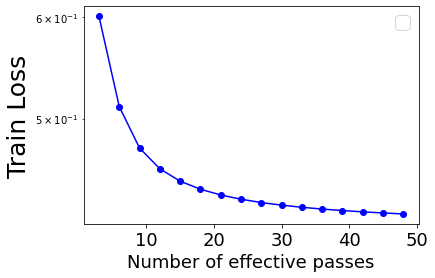

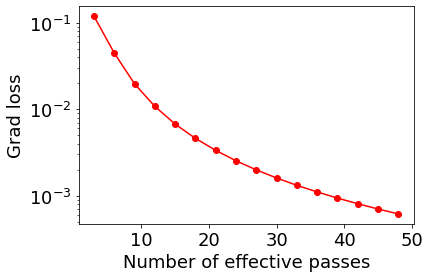

In [3]:
plot_loss(history)
plot_norm_square_grad(history)

## SMG with Diminishing Learning Rate Scheduler

In [ ]:
criterion = nn.SoftMarginLoss()

model = NonconvexLogisticNet(22, 1, 128)
model = model.to(device)
epochs = 50


scheduler = diminishing_learning_rate_scheduler(0.001, 8)

# beta is proposed in paper and epoch_count is inferenced from the graphs
history = SMG_train(model, criterion, epochs, ijcnn1_train_loader, ijcnn1_test_loader,
                    scheduler, beta=0.5, verbose=True)

Epoch 1 / 50: avg. loss of last epoch 0.6810922811140556
avg. grad_norm of last epoch 0.1848743896999222
Current train acc: 63.85477095419084%, test acc: 66.59578412449156%
Epoch 2 / 50: avg. loss of last epoch 0.657006043018067
avg. grad_norm of last epoch 0.16845549304262955
Current train acc: 80.28605721144228%, test acc: 80.02093761245789%
Epoch 3 / 50: avg. loss of last epoch 0.6285947405116323
avg. grad_norm of last epoch 0.14661744558394588
Current train acc: 85.57111422284457%, test acc: 85.00561607834156%
Epoch 4 / 50: avg. loss of last epoch 0.6045397039221914
avg. grad_norm of last epoch 0.12624473683625326
Current train acc: 90.07001400280056%, test acc: 90.15932214479668%
Epoch 5 / 50: avg. loss of last epoch 0.5844647329076339
avg. grad_norm of last epoch 0.10833208983551516
Current train acc: 90.29205841168233%, test acc: 90.46357182582524%
Epoch 6 / 50: avg. loss of last epoch 0.5676203232332333
avg. grad_norm of last epoch 0.09326774125345559
Current train acc: 90.2920

In [ ]:
#Save the history
save_history_json("/content/gdrive/MyDrive/SMGExperiments/SMG-ijcnn1-History/SMG_diminishingLR.json", history)

No handles with labels found to put in legend.


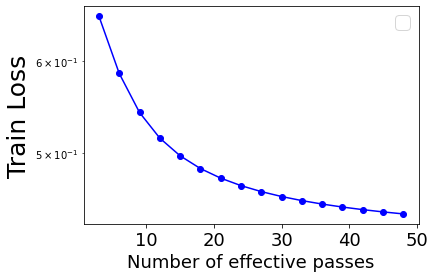

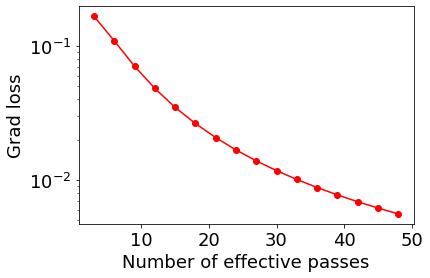

In [4]:
plot_loss(history)
plot_norm_square_grad(history)

## SMG with Exponential Learning Rate Scheduler

In [ ]:
criterion = nn.SoftMarginLoss()

model = NonconvexLogisticNet(22, 1, 128)
model = model.to(device)
epochs = 50

scheduler = exponential_learning_rate_scheduler(0.005, 0.99)

# beta is proposed in paper and epoch_count is inferenced from the graphs
history = SMG_train(model, criterion, epochs, ijcnn1_train_loader, ijcnn1_test_loader,
                    scheduler, beta=0.5, verbose=True)

Epoch 1 / 50: avg. loss of last epoch 0.6238250480696881
avg. grad_norm of last epoch 0.1374976556667395
Current train acc: 90.29005801160233%, test acc: 90.47883883490911%
Epoch 2 / 50: avg. loss of last epoch 0.5033391393680863
avg. grad_norm of last epoch 0.04026102760837532
Current train acc: 90.29205841168233%, test acc: 90.49955834723721%
Epoch 3 / 50: avg. loss of last epoch 0.44971089856246343
avg. grad_norm of last epoch 0.007872743311910575
Current train acc: 90.29205841168233%, test acc: 90.49955834723721%
Epoch 4 / 50: avg. loss of last epoch 0.4357909031070741
avg. grad_norm of last epoch 0.003278279446828811
Current train acc: 90.29205841168233%, test acc: 90.49955834723721%
Epoch 5 / 50: avg. loss of last epoch 0.43022876129457516
avg. grad_norm of last epoch 0.00198849289419429
Current train acc: 90.29205841168233%, test acc: 90.49955834723721%
Epoch 6 / 50: avg. loss of last epoch 0.4269510105302941
avg. grad_norm of last epoch 0.0013843957134276937
Current train acc: 

In [ ]:
#Save the history
save_history_json("/content/gdrive/MyDrive/SMGExperiments/SMG-ijcnn1-History/SMG_ExponentialLR.json", history)

No handles with labels found to put in legend.


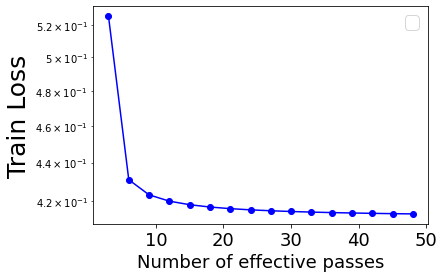

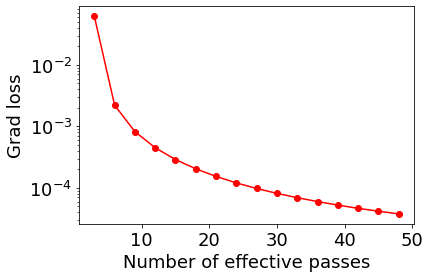

In [6]:
plot_loss(history)
plot_norm_square_grad(history)

## SMG with Cosine Learning Rate Scheduler

In [ ]:
criterion = nn.SoftMarginLoss()

model = NonconvexLogisticNet(22, 1, 128)
model = model.to(device)
epochs = 50


scheduler = cosine_learning_rate_scheduler(0.005, epochs)

# beta is proposed in paper and epoch_count is inferred from the graphs
history = SMG_train(model, criterion, epochs, ijcnn1_train_loader, ijcnn1_test_loader,
                    scheduler, beta=0.5, verbose=True)

Epoch 1 / 50: avg. loss of last epoch 0.5638828715769667
avg. grad_norm of last epoch 0.08817237183838186
Current train acc: 90.29205841168233%, test acc: 90.49955834723721%
Epoch 2 / 50: avg. loss of last epoch 0.45394178643706407
avg. grad_norm of last epoch 0.010866333843714188
Current train acc: 90.29205841168233%, test acc: 90.49955834723721%
Epoch 3 / 50: avg. loss of last epoch 0.424687924970982
avg. grad_norm of last epoch 0.0010459308835357836
Current train acc: 90.29205841168233%, test acc: 90.49955834723721%
Epoch 4 / 50: avg. loss of last epoch 0.420219849830724
avg. grad_norm of last epoch 0.00047534866512584037
Current train acc: 90.29205841168233%, test acc: 90.49955834723721%
Epoch 5 / 50: avg. loss of last epoch 0.41855777050762544
avg. grad_norm of last epoch 0.00032544866356446644
Current train acc: 90.29205841168233%, test acc: 90.49955834723721%
Epoch 6 / 50: avg. loss of last epoch 0.4174787049175237
avg. grad_norm of last epoch 0.0002406291845232508
Current train

In [ ]:
#Save the history
save_history_json("/content/gdrive/MyDrive/SMGExperiments/SMG-ijcnn1-History/SMG_CosineLR.json", history)

No handles with labels found to put in legend.


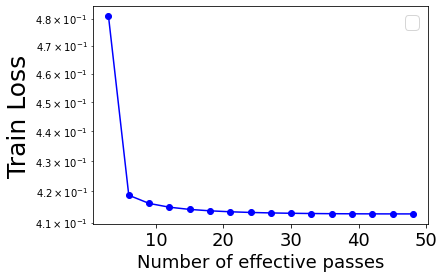

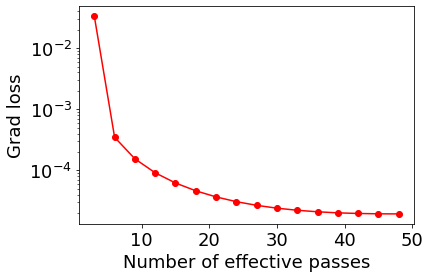

In [8]:
plot_loss(history)
plot_norm_square_grad(history)

# 2- Train Other Models and Compare over SMG

## Training with Adam


In [ ]:
import torch.optim as optim

criterion = nn.SoftMarginLoss()

model = NonconvexLogisticNet(22, 1, 128)
model = model.to(device)
epochs = 50


scheduler = constant_learning_rate_scheduler(0.001)
optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999))

adam_history = train(model, criterion, optimizer, epochs, ijcnn1_train_loader, ijcnn1_test_loader, scheduler)

Epoch 1 / 50: avg. loss of last epoch 0.5370973212918317
Epoch 1 / 50: avg. grad_norm of last epoch 0.06850565947644957
Current train acc: 90.29205841168233%, test acc: 90.50064884788607%
Epoch 2 / 50: avg. loss of last epoch 0.45217592751986985
Epoch 2 / 50: avg. grad_norm of last epoch 0.00958313569290679
Current train acc: 90.29205841168233%, test acc: 90.49955834723721%
Epoch 3 / 50: avg. loss of last epoch 0.4308845727604423
Epoch 3 / 50: avg. grad_norm of last epoch 0.0023513583066106522
Current train acc: 90.29205841168233%, test acc: 90.49955834723721%
Epoch 4 / 50: avg. loss of last epoch 0.42257538335302786
Epoch 4 / 50: avg. grad_norm of last epoch 0.0008414971048858773
Current train acc: 90.29205841168233%, test acc: 90.49955834723721%
Epoch 5 / 50: avg. loss of last epoch 0.4184379188149754
Epoch 5 / 50: avg. grad_norm of last epoch 0.0003701152392992539
Current train acc: 90.29205841168233%, test acc: 90.50064884788607%
Epoch 6 / 50: avg. loss of last epoch 0.416047158717

In [ ]:
#Save the history
save_history_json("/content/gdrive/MyDrive/SMGExperiments/ijcnn1-Other-Optimizers/ADAM_constantLR.json", adam_history)

No handles with labels found to put in legend.


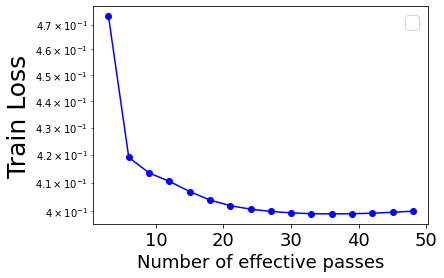

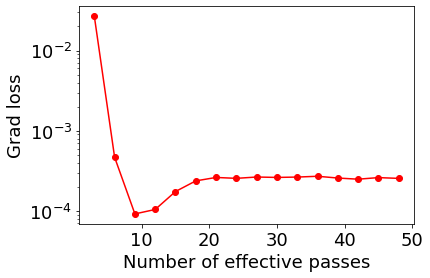

In [9]:
plot_loss(adam_history)
plot_norm_square_grad(adam_history)

## Training with SGD


In [ ]:
import torch.optim as optim
criterion = nn.SoftMarginLoss()

model = NonconvexLogisticNet(22, 1, 128)
model = model.to(device)
epochs = 50

scheduler = constant_learning_rate_scheduler(0.001)
optimizer = optim.SGD(model.parameters(), lr=0.001)

sgd_history = train(model, criterion, optimizer, epochs, ijcnn1_train_loader, ijcnn1_test_loader, scheduler)

Epoch 1 / 50: avg. loss of last epoch 0.7155439224975734
Epoch 1 / 50: avg. grad_norm of last epoch 0.20015173017169044
Current train acc: 55.30106021204241%, test acc: 50.58723459940459%
Epoch 2 / 50: avg. loss of last epoch 0.6462920671559541
Epoch 2 / 50: avg. grad_norm of last epoch 0.15859743417687072
Current train acc: 85.38107621524306%, test acc: 79.70796392623853%
Epoch 3 / 50: avg. loss of last epoch 0.5938662909393098
Epoch 3 / 50: avg. grad_norm of last epoch 0.11589656765436691
Current train acc: 90.29205841168233%, test acc: 90.49955834723721%
Epoch 4 / 50: avg. loss of last epoch 0.5562029058371911
Epoch 4 / 50: avg. grad_norm of last epoch 0.08269721705332288
Current train acc: 90.29205841168233%, test acc: 90.49955834723721%
Epoch 5 / 50: avg. loss of last epoch 0.5293289538287334
Epoch 5 / 50: avg. grad_norm of last epoch 0.05951797034789156
Current train acc: 90.29205841168233%, test acc: 90.49955834723721%
Epoch 6 / 50: avg. loss of last epoch 0.5098343995195029
Epo

In [ ]:
#Save the history
save_history_json("/content/gdrive/MyDrive/SMGExperiments/ijcnn1-Other-Optimizers/SGD_constantLR.json", sgd_history)

No handles with labels found to put in legend.


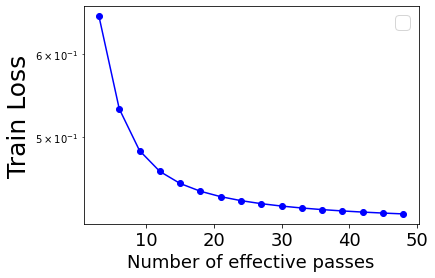

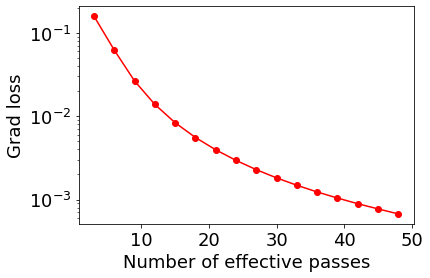

In [10]:
plot_loss(sgd_history)
plot_norm_square_grad(sgd_history)

## Training with SGD-M

In [ ]:
import torch.optim as optim
criterion = nn.SoftMarginLoss()

model = NonconvexLogisticNet(22, 1, 128)
model = model.to(device)
epochs = 50

scheduler = constant_learning_rate_scheduler(0.001)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.5)

sgdm_history = train(model, criterion, optimizer, epochs, ijcnn1_train_loader, ijcnn1_test_loader, scheduler)

Epoch 1 / 50: avg. loss of last epoch 0.6086183613623398
Epoch 1 / 50: avg. grad_norm of last epoch 0.12678474417781516
Current train acc: 90.25205041008202%, test acc: 89.93031700853862%
Epoch 2 / 50: avg. loss of last epoch 0.537078802698635
Epoch 2 / 50: avg. grad_norm of last epoch 0.06629700518281725
Current train acc: 90.29205841168233%, test acc: 90.49301534334413%
Epoch 3 / 50: avg. loss of last epoch 0.4994245651519928
Epoch 3 / 50: avg. grad_norm of last epoch 0.03641728919431807
Current train acc: 90.29205841168233%, test acc: 90.49955834723721%
Epoch 4 / 50: avg. loss of last epoch 0.47792705507916555
Epoch 4 / 50: avg. grad_norm of last epoch 0.022023782073608392
Current train acc: 90.29205841168233%, test acc: 90.49955834723721%
Epoch 5 / 50: avg. loss of last epoch 0.4644500734281915
Epoch 5 / 50: avg. grad_norm of last epoch 0.014502538951398202
Current train acc: 90.29205841168233%, test acc: 90.49955834723721%
Epoch 6 / 50: avg. loss of last epoch 0.45533611072161406


In [ ]:
#Save the history
save_history_json("/content/gdrive/MyDrive/SMGExperiments/ijcnn1-Other-Optimizers/SGD-M_constantLR.json", sgdm_history)

No handles with labels found to put in legend.


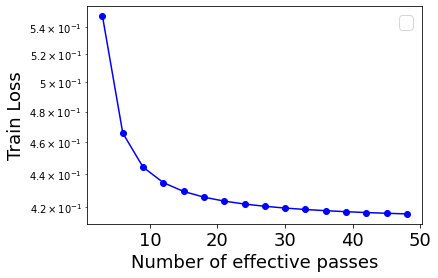

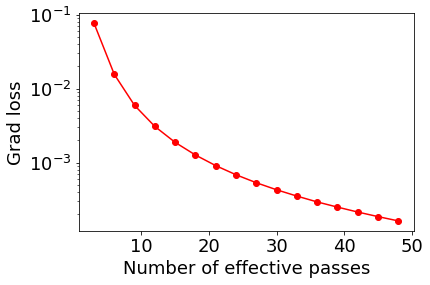

In [12]:
plot_loss(sgdm_history)
plot_norm_square_grad(sgdm_history)

## Training with SSMG


In [ ]:
import torch.optim as optim

criterion = nn.SoftMarginLoss()

model = NonconvexLogisticNet(22, 1, 128)
model = model.to(device)
epochs = 50


scheduler = constant_learning_rate_scheduler(0.001)

#SSMG is single shuffle variant of the SMG (with different optimizer step.) 
#Thus, reload the batch by shuffling it once and disable shuffling in every epoch
ijcnn1_train_loader, ijcnn1_test_loader = ijcnn1_data_loader(ijcnn1_X_train, ijcnn1_Y_train, ijcnn1_X_test, ijcnn1_Y_test, 128, True)

# beta is proposed in paper and epoch_count is inferenced from the graphs
ssmgHistory = SSMG_train(model, criterion, epochs, ijcnn1_train_loader, ijcnn1_test_loader, 
                    scheduler, beta=0.5, verbose=True)

Epoch 1 / 50: avg. loss of last epoch 0.6411458674348052
avg. grad_norm of last epoch 0.1551325892873933
Current train acc: 87.06741348269654%, test acc: 86.77004612817744%
Epoch 2 / 50: avg. loss of last epoch 0.5900210023808662
avg. grad_norm of last epoch 0.11268823939190324
Current train acc: 89.9879975995199%, test acc: 89.80709043521881%
Epoch 3 / 50: avg. loss of last epoch 0.5534423506100146
avg. grad_norm of last epoch 0.08029875899344024
Current train acc: 90.29005801160233%, test acc: 90.31962574017732%
Epoch 4 / 50: avg. loss of last epoch 0.5273483622572518
avg. grad_norm of last epoch 0.0578736883592534
Current train acc: 90.29205841168233%, test acc: 90.45920982322984%
Epoch 5 / 50: avg. loss of last epoch 0.5083883096704866
avg. grad_norm of last epoch 0.04270823808298062
Current train acc: 90.29205841168233%, test acc: 90.50173934853491%
Epoch 6 / 50: avg. loss of last epoch 0.49425361552317626
avg. grad_norm of last epoch 0.032360050701861036
Current train acc: 90.292

In [ ]:
#Save the history
save_history_json("/content/gdrive/MyDrive/SMGExperiments/ijcnn1-Other-Optimizers/SSMG_constantLR.json", ssmgHistory)

No handles with labels found to put in legend.


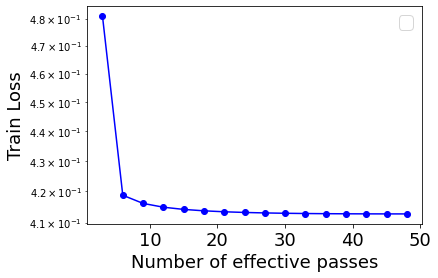

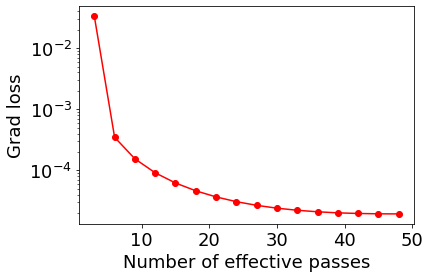

In [13]:
plot_loss(ssmgHistory)
plot_norm_square_grad(ssmgHistory)